- 基于以上数据，以物资编码为单位，以申请数量为目标变量，对每类物资未来3个月分月(未来5周分周)的需求进行预测。
- 要求:
1. 将模型拆分为数据预处理、
2. 需求类型判别、
3. 常用物资时间序列模型(具体应用哪种模型或者模型组合不重要，重要的是结果要不离谱)、
4. 零星偶发物资需求预测(如果历史数据太少，可以参考历史统计量进行简单规则设定)、
5. 结果整合输出(预测结果的判别和优化) 几个模块。
- 重点要求模型的健壮性，对于不同类型物资的输入，都要给出一个不离谱的结果，所以需要增加一些结果判别和修正规则(如预测结果不能为负、与历史统计量的对比不能偏差过大等)。
- 模型可以适应最新数据加入的选代更新。

#### 数据处理、需求类型分类

In [3]:
def transData(df):
    df = df.drop(['业务单号', '升级物资规格编码', '计量单位', '仓库领料数量', '直送现场数量'], axis=1)
    df = df.sort_values(by='调拨日期')

    # 统计"升级物资编码"中每个类别的出现次数
    counts = df['升级物资编码'].value_counts()

    # 将出现次数大于等于500的类别提取到"CY" DataFrame中，其他的提取到"SY" DataFrame中
    CY = counts[counts >= 500].index.to_list()  # len：92
    SY = counts[counts < 500].index.to_list()  # len：669

    # 将 "CY" 和 "SY" DataFrame 中每个升级物资编码的数据提取到相应的列表中。
    # CYList 和 SYList 列表中，每个元素都是一个字典，包含了相应升级物资编码的所有数据。
    CYList = {}
    SYList = {}
    
    for i in CY:
        v = df[df['升级物资编码'] == i].drop('升级物资编码', axis=1)
        v.set_index('调拨日期', inplace=True)
        v1 = v
        CYList[str(i)] = [v.groupby(pd.Grouper(freq='W')).sum().reset_index(), v1.groupby(pd.Grouper(freq='M')).sum().reset_index()]
        # CYList[str(i)] = [v.groupby(pd.Grouper(freq='W')).sum(), v1.groupby(pd.Grouper(freq='M')).sum()]
    for i in SY:
        v = df[df['升级物资编码'] == i].drop('升级物资编码', axis=1)
        v.set_index('调拨日期', inplace=True)
        v1 = v
        SYList[str(i)] = [v.groupby(pd.Grouper(freq='W')).sum().reset_index(), v1.groupby(pd.Grouper(freq='M')).sum().reset_index()]
        # SYList[str(i)] = [v.groupby(pd.Grouper(freq='W')).sum(), v1.groupby(pd.Grouper(freq='M')).sum()]


    return CYList, SYList

#### 常用物资时间序列模型

##### 未来5周分周的需求预测

In [4]:
def CYWeek(code, XLdata, steps):
    """常用物资，未来几周预测
    code：升级物资编码
    XLdata：序列数据，即dataframe
    """
    q1 = XLdata['申请数量'].quantile(0.25)
    q3 = XLdata['申请数量'].quantile(0.75)
    iqr = q3 - q1

    # 计算异常值的范围
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # 使用loc函数去除异常值
    XLdata = XLdata.loc[(XLdata['申请数量'] >= lower_bound) & (XLdata['申请数量'] <= upper_bound)]
    ts = pd.Series(XLdata['申请数量'].values, index=XLdata['调拨日期'], name='周申请数量')
    
    # 使用ARIMA模型训练
    model = ARIMA(ts, order=(1, 1, 1))  # 这里使用了ARIMA(p, d, q)的参数，你可以根据需要调整
    model_fit = model.fit()

    # 预测未来几周的数据
    forecast_values = model_fit.forecast(steps=steps)

    # 获取ts的最后一个日期
    last_date = ts.index[-1]

    # 创建包含forecast_values的Pandas Series，确保索引是按顺序的
    forecast = pd.Series(forecast_values.to_list(), 
                                index=pd.date_range(start=last_date + pd.DateOffset(weeks=1), periods=steps, freq='W'))

    print('升级物资编码为：'+code + ' 的未来' + str(steps) + '周的预测值为：\n', forecast)

    # 使用pd.concat将ts和forecast_values合并
    combined_series = pd.concat([ts, forecast])

    # 创建一个图形
    plt.figure(figsize=(12, 6))
    # 绘制已有数据部分，用蓝色表示
    plt.plot(combined_series.iloc[:-steps], label='Training Data')
    # 绘制后预测值，用红色表示
    plt.plot(combined_series.iloc[-steps:], label='Forecast', color='red')
    # 设置横轴和纵轴标签以及标题
    plt.xlabel('时间')
    plt.ylabel('申请数量')
    plt.title(code + ' 的未来' + str(steps) + '周 ARIMA 模型预测结果')
    plt.legend()
    plt.show()

    return forecast

##### 未来3个月分月的需求预测

In [5]:
def CYMonth(code, XLdata, steps):
    """常用物资，未来几个月预测
    code：升级物资编码
    XLdata：序列数据，即dataframe
    """
    q1 = XLdata['申请数量'].quantile(0.25)
    q3 = XLdata['申请数量'].quantile(0.75)
    iqr = q3 - q1

    # 计算异常值的范围
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # 使用loc函数去除异常值
    XLdata = XLdata.loc[(XLdata['申请数量'] >= lower_bound) & (XLdata['申请数量'] <= upper_bound)]
    ts = pd.Series(XLdata['申请数量'].values, index=XLdata['调拨日期'], name='月申请数量')
    
    # 使用ARIMA模型训练
    model = ARIMA(ts, order=(1, 1, 1))  # 这里使用了ARIMA(p, d, q)的参数，你可以根据需要调整
    model_fit = model.fit()

    # 预测未来几个月的数据
    forecast_values = model_fit.forecast(steps=steps)

    # 获取ts的最后一个日期
    last_date = ts.index[-1]

    # 创建包含forecast_values的Pandas Series，确保索引是按顺序的
    forecast = pd.Series(forecast_values.to_list(), 
                         index=pd.date_range(start=last_date + pd.DateOffset(months=1), periods=steps, freq='M'))

    print('升级物资编码为：'+code + ' 的未来' + str(steps) + '个月的预测值为：\n', forecast)

    # 使用pd.concat将ts和forecast_values合并
    combined_series = pd.concat([ts, forecast])

    # 创建一个图形
    plt.figure(figsize=(12, 6))
    # 绘制前面部分，用蓝色表示
    plt.plot(combined_series.iloc[:-steps], label='Training Data')
    # 绘制后几个月的值，用红色表示
    plt.plot(combined_series.iloc[-steps:], label='Forecast', color='red')
    # 设置横轴和纵轴标签以及标题
    plt.xlabel('时间')
    plt.ylabel('申请数量')
    plt.title(code + ' 的未来' + str(steps) + '个月 ARIMA 模型预测结果')
    # 添加图例
    plt.legend()
    # 显示图形
    plt.show()

    return forecast

### 零星偶发物资需求预测

##### 未来5周分周的需求预测

In [6]:
def SYWeek(code, XLdata, steps):
    """少用物资，未来几周预测
    code：升级物资编码
    XLdata：序列数据，即dataframe
    """
    q1 = XLdata['申请数量'].quantile(0.25)
    q3 = XLdata['申请数量'].quantile(0.75)
    iqr = q3 - q1

    # 计算异常值的范围
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # 使用loc函数去除异常值
    XLdata = XLdata.loc[(XLdata['申请数量'] >= lower_bound) & (XLdata['申请数量'] <= upper_bound)]
    ts = pd.Series(XLdata['申请数量'].values, index=XLdata['调拨日期'], name='周申请数量')
    
    # 使用ARIMA模型训练
    model = ARIMA(ts, order=(1, 1, 1))  # 这里使用了ARIMA(p, d, q)的参数，你可以根据需要调整
    model_fit = model.fit()

    # 预测未来几周的数据
    forecast_values = model_fit.forecast(steps=steps)

    # 获取ts的最后一个日期
    last_date = ts.index[-1]

    # 创建包含forecast_values的Pandas Series，确保索引是按顺序的
    forecast = pd.Series(forecast_values.to_list(), 
                                index=pd.date_range(start=last_date + pd.DateOffset(weeks=1), periods=steps, freq='W'))

    print('升级物资编码为：'+code + ' 的未来' + str(steps) + '周的预测值为：\n', forecast)

    # 使用pd.concat将ts和forecast_values合并
    combined_series = pd.concat([ts, forecast])

    # 创建一个图形
    plt.figure(figsize=(12, 6))
    # 绘制已有数据部分，用蓝色表示
    plt.plot(combined_series.iloc[:-steps], label='Training Data')
    # 绘制后预测值，用红色表示
    plt.plot(combined_series.iloc[-steps:], label='Forecast', color='red')
    # 设置横轴和纵轴标签以及标题
    plt.xlabel('时间')
    plt.ylabel('申请数量')
    plt.title(code + ' 的未来' + str(steps) + '周 ARIMA 模型预测结果')
    plt.legend()
    plt.show()

    return forecast

##### 未来3个月分月的需求预测

In [7]:
def SYMonth(code, XLdata, steps):
    """少用物资，未来几个月预测
    code：升级物资编码
    XLdata：序列数据，即dataframe
    """
    q1 = XLdata['申请数量'].quantile(0.25)
    q3 = XLdata['申请数量'].quantile(0.75)
    iqr = q3 - q1

    # 计算异常值的范围
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # 使用loc函数去除异常值
    XLdata = XLdata.loc[(XLdata['申请数量'] >= lower_bound) & (XLdata['申请数量'] <= upper_bound)]
    ts = pd.Series(XLdata['申请数量'].values, index=XLdata['调拨日期'], name='月申请数量')
    
    # 使用ARIMA模型训练
    model = ARIMA(ts, order=(1, 1, 1))  # 这里使用了ARIMA(p, d, q)的参数，你可以根据需要调整
    model_fit = model.fit()

    # 预测未来几个月的数据
    forecast_values = model_fit.forecast(steps=steps)

    # 获取ts的最后一个日期
    last_date = ts.index[-1]

    # 创建包含forecast_values的Pandas Series，确保索引是按顺序的
    forecast = pd.Series(forecast_values.to_list(), 
                         index=pd.date_range(start=last_date + pd.DateOffset(months=1), periods=steps, freq='M'))

    print('升级物资编码为：'+code + ' 的未来' + str(steps) + '个月的预测值为：\n', forecast)

    # 使用pd.concat将ts和forecast_values合并
    combined_series = pd.concat([ts, forecast])

    # 创建一个图形
    plt.figure(figsize=(12, 6))
    # 绘制前面部分，用蓝色表示
    plt.plot(combined_series.iloc[:-steps], label='Training Data')
    # 绘制后几个月的值，用红色表示
    plt.plot(combined_series.iloc[-steps:], label='Forecast', color='red')
    # 设置横轴和纵轴标签以及标题
    plt.xlabel('时间')
    plt.ylabel('申请数量')
    plt.title(code + ' 的未来' + str(steps) + '个月 ARIMA 模型预测结果')
    # 添加图例
    plt.legend()
    # 显示图形
    plt.show()

    return forecast

### 结果整合输出

In [10]:
def predict(CYList, SYList, code, WorM, steps):
    if code in CYList:
        if WorM == 'w':
            CYWeek(code, CYList[code][0], steps)
        elif WorM == 'm':
            CYMonth(code, CYList[code][1], steps)
    elif code in SYList:
        if WorM == 'w':
            SYWeek(code, SYList[code][0], steps)
        elif WorM == 'm':
            SYMonth(code, SYList[code][1], steps)
    else: return "请输入正确的升级物资编码"

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# 指定系统中已安装的中文字体，例如SimSun或Microsoft YaHei
plt.rcParams['font.family'] = 'SimSun'

# 如果您需要显示中文标签，可以设置以下参数
plt.rcParams['axes.unicode_minus'] = False  # 处理坐标轴负号显示问题

# 读取xlsx文件
data = pd.read_excel('data.xlsx')

CYList, SYList = transData(data)

d:\DSW\Conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\DSW\Conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\DSW\Conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\DSW\Conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


升级物资编码为：10044117716 的未来5周的预测值为：
 2023-06-18    28.234866
2023-06-25    29.301872
2023-07-02    29.580721
2023-07-09    29.653595
2023-07-16    29.672640
Freq: W-SUN, dtype: float64


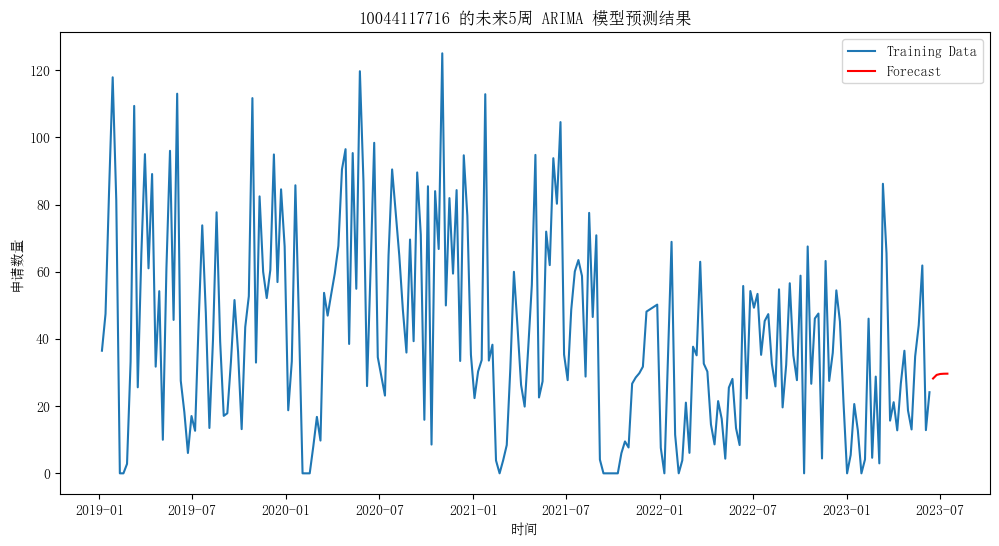

d:\DSW\Conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\DSW\Conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\DSW\Conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\DSW\Conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\DSW\Conda\lib\site-packages\statsmo

升级物资编码为：10044117716 的未来3个月的预测值为：
 2023-06-30    144.010805
2023-07-31    139.868370
2023-08-31    139.076984
Freq: M, dtype: float64


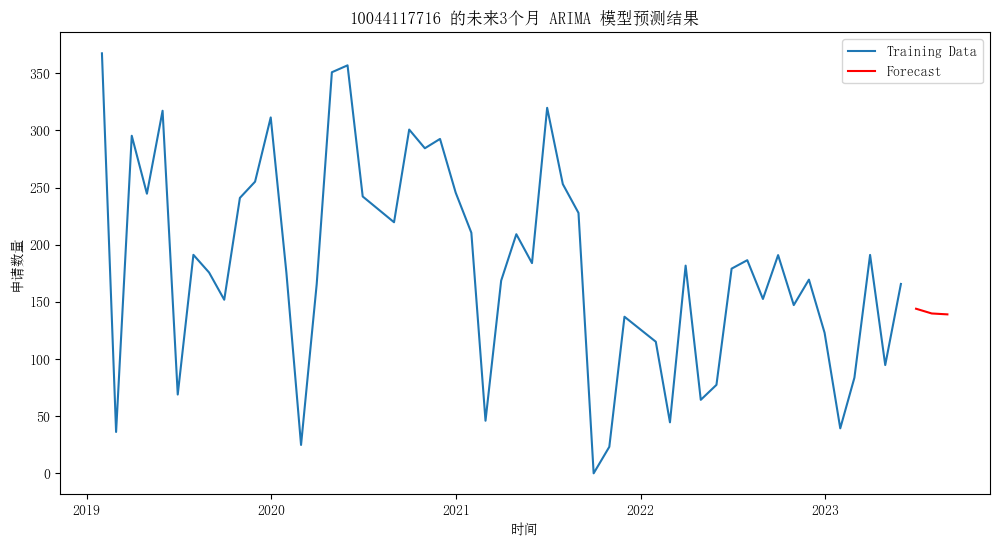

d:\DSW\Conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\DSW\Conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\DSW\Conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\DSW\Conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


升级物资编码为：10001103406 的未来5周的预测值为：
 2023-06-11    0.567762
2023-06-18    0.479027
2023-06-25    0.460810
2023-07-02    0.457070
2023-07-09    0.456303
Freq: W-SUN, dtype: float64


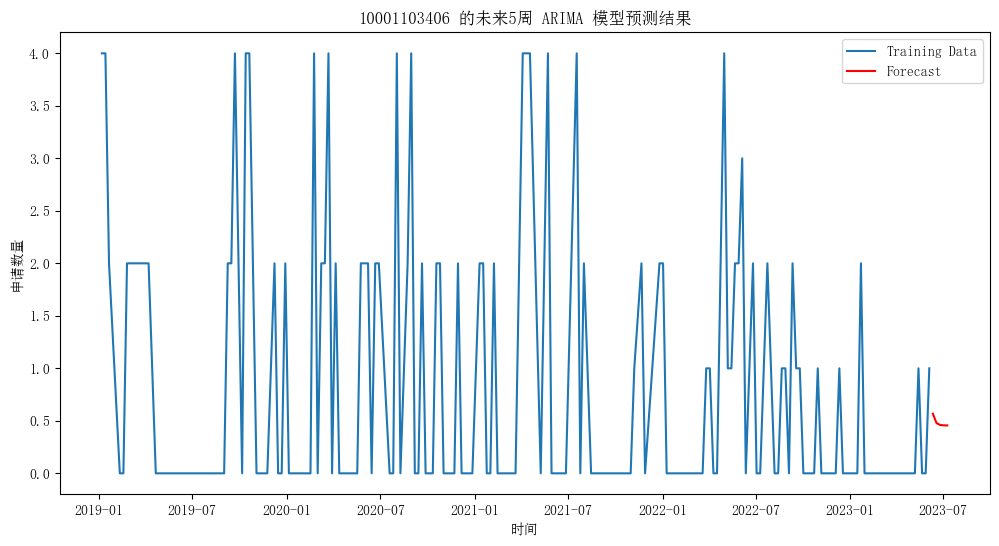

d:\DSW\Conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\DSW\Conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\DSW\Conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\DSW\Conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\DSW\Conda\lib\site-packages\statsmodels\tsa\base\tsa

升级物资编码为：10001103406 的未来3个月的预测值为：
 2023-07-31    2.959408
2023-08-31    3.501183
2023-09-30    3.650984
Freq: M, dtype: float64


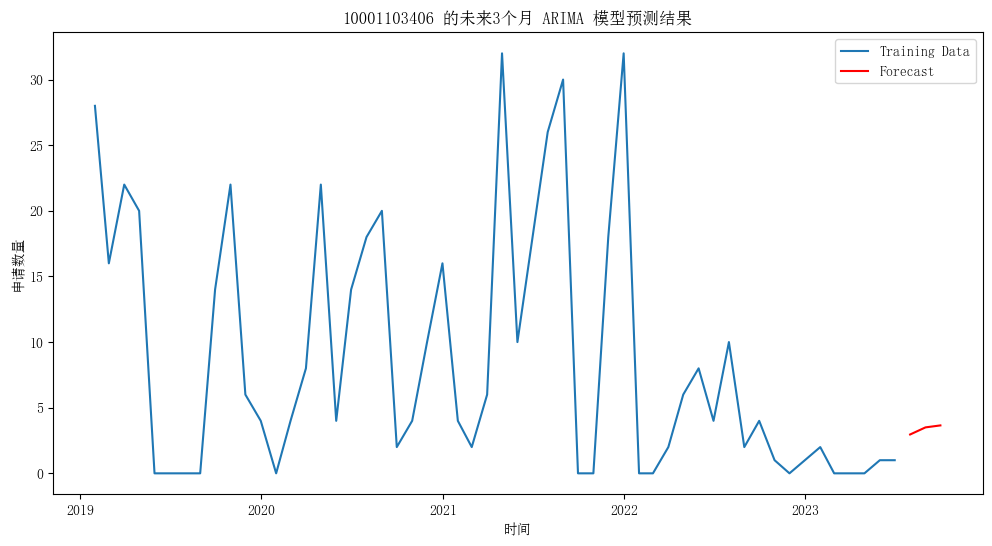

In [11]:
predict(CYList, SYList, '10044117716', 'w', 5)
predict(CYList, SYList, '10044117716', 'm', 3)
predict(CYList, SYList, '10001103406', 'w', 5)
predict(CYList, SYList, '10001103406', 'm', 3)